In [1]:
%matplotlib inline
import matplotlib.pylab as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import transforms, datasets

from torchmin import minimize_constr

In [2]:
device = torch.device('cuda:0')

root = '/path/to/data'  # fill in torchvision dataset path
train_data = datasets.MNIST(root, train=True, transform=transforms.ToTensor())
train_loader = DataLoader(train_data, batch_size=128, shuffle=True)

# Train CNN classifier

In [3]:
def CNN():
    return nn.Sequential(
        nn.Conv2d(1, 10, kernel_size=5),
        nn.SiLU(),
        nn.AvgPool2d(2),
        nn.Conv2d(10, 20, kernel_size=5),
        nn.SiLU(),
        nn.AvgPool2d(2),
        nn.Dropout(0.2),
        nn.Flatten(1),
        nn.Linear(320, 50),
        nn.Dropout(0.2),
        nn.Linear(50, 10),
        nn.LogSoftmax(1)
    )

In [4]:
torch.manual_seed(382)
net = CNN().to(device)
optimizer = optim.Adam(net.parameters())
for epoch in range(10):
    epoch_loss = 0
    for (x, y) in train_loader:
        x = x.to(device, non_blocking=True)
        y = y.to(device, non_blocking=True)
        logits = net(x)
        loss = F.nll_loss(logits, y)
        optimizer.zero_grad(set_to_none=True)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item() * x.size(0)
    print('epoch %2d - loss: %0.4f' % (epoch+1, epoch_loss / len(train_data)))

epoch  1 - loss: 0.4923
epoch  2 - loss: 0.1428
epoch  3 - loss: 0.1048
epoch  4 - loss: 0.0883
epoch  5 - loss: 0.0754
epoch  6 - loss: 0.0672
epoch  7 - loss: 0.0626
epoch  8 - loss: 0.0578
epoch  9 - loss: 0.0524
epoch 10 - loss: 0.0509


# set up adversarial example environment

In [6]:
# evaluation mode settings
net = net.requires_grad_(False).eval()

# move net to CPU
# Note: using CUDA-based inputs and objectives is allowed
# but inefficient with trust-constr, as the data will be
# moved back-and-forth from CPU
net = net.cpu()

In [7]:
def nll_objective(x, y):
    assert x.numel() == 28**2
    assert y.numel() == 1
    x = x.view(1, 1, 28, 28)
    return F.nll_loss(net(x), y.view(1))

In [8]:
# select a random image from the dataset
torch.manual_seed(338)
x, y = next(iter(train_loader))
img = x[0]
label = y[0]

In [9]:
nll_objective(img, label)

tensor(1.4663e-05)

In [10]:
# minimization objective for adversarial examples
#   goal is to maximize NLL of perturbed image (image + perturbation)
fn = lambda eps: - nll_objective(img + eps, label)

In [18]:
# plotting utility

def plot_distortion(img, eps, y):
    assert img.numel() == 28**2
    assert eps.numel() == 28**2
    img = img.view(28, 28)
    img_ = img + eps.view(28, 28)
    fig, axes = plt.subplots(1,2,figsize=(4,2))
    for i, x in enumerate((img, img_)):
        axes[i].imshow(x.cpu(), cmap=plt.cm.binary)
        axes[i].set_xticks([])
        axes[i].set_yticks([])
        axes[i].set_title('nll: %0.4f' % nll_objective(x, y))
    plt.show()

# craft adversarial example

We will use our constrained optimizer to find the optimal unit-norm purturbation $\epsilon$ 

\begin{equation}
\max_{\epsilon} NLL(x + \epsilon) \quad \text{s.t.} \quad ||\epsilon|| = 1
\end{equation}

In [13]:
torch.manual_seed(227)
eps0 = torch.randn_like(img)
eps0 /= eps0.norm()

In [14]:
fn(eps0).item()

-2.2291887944447808e-05

In [15]:
res = minimize_constr(
    fn, eps0, 
    max_iter=100,
    constr=dict(
        fun=lambda x: x.square().sum(), 
        lb=1, ub=1
    ),
    disp=1
)

`xtol` termination condition is satisfied.
Number of iterations: 32, function evaluations: 50, CG iterations: 52, optimality: 1.02e-04, constraint violation: 0.00e+00, execution time: 0.57 s.


In [16]:
eps = res.x
print(eps.norm())

tensor(1.)


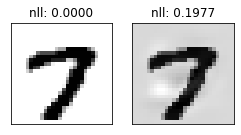

In [19]:
plot_distortion(img.detach(), eps, label)